In [1]:
import stock_analyzer as sa
import glob
import pandas as pd
import numpy as np
import mplfinance as mpf

In [2]:
saHandler = sa.StockViewer("./archive")

In [3]:
example_stocks = sorted([(k, v) for k, v in saHandler.stocks.items() if v['insider_size'] > 100])
example_string = [f"{k}:\t{v['insider_size']}" for k,v in example_stocks]
ticker_names = [k for k, _ in example_stocks]
print('Stocks with insider size larger than 100:\n' + "\n".join(example_string))

Stocks with insider size larger than 100:
ANET:	108
BSX:	104
CRM:	158
DRI:	108
ED:	102
ETSY:	109
EW:	108
FFIV:	101
GOOG:	107
IT:	101
MRNA:	141
NOW:	105
PG:	101
REGN:	104
SCHW:	104
TSLA:	105
WMT:	101


### Visualizing historical data with insider data

Matplotlib finance is a useful tool to visualize historical prices.

In addition to library you can find the implementation and visualization of:
- Bollinger Bands
- Moving Average
- Exponential Moving Average

In views, the insider data is included. The below symbols is the legends for transactions.

- ▲ means buy
- ▼ means sale
- ⏺ means option exercise

The size of symbols are proportional to their value. Bigger the symbols, higher the amount. 

For the option exercise, we don't know if it is put or call option.

Each person is colored differently

Views can be **daily** or **weekly**. Just add **weekly=True** to arguments if you would like to see weekly view

To have a better view and calculate ma and bollinger for longer period, the data request starts from 120 days before the first insider transaction and ends 120 days after the last insider transaction. To manually change start and end offsets, arguments **forward_timedelta**  and **backward_timedelta** can be assigned

Each time a plot is called, it first checks the data is present on cache. If it is downloaded before, it doesn't download the data again. To overwrite this, use **force_download=True**


Below examples show how to use them

[*********************100%***********************]  1 of 1 completed


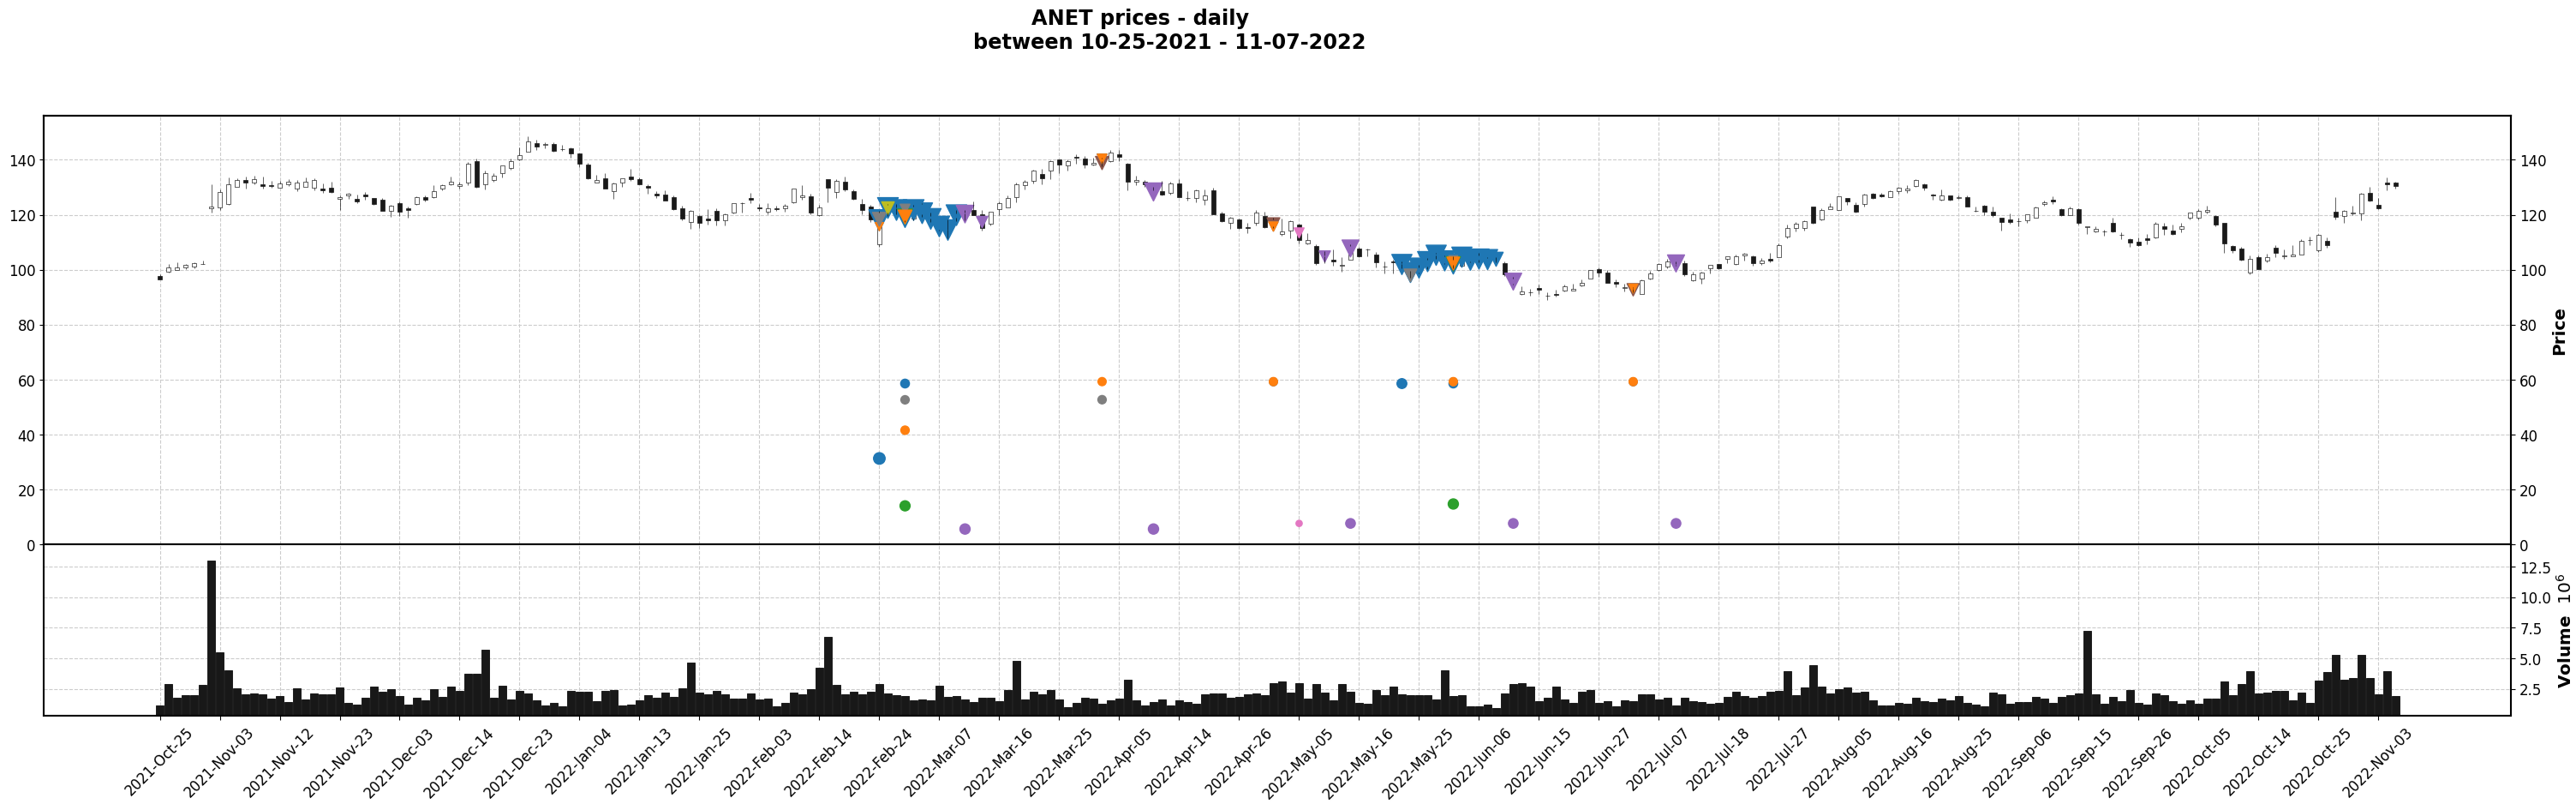

In [4]:
# Default View
saHandler.plot_stock_data(ticker_names[0], volume=True)

[*********************100%***********************]  1 of 1 completed


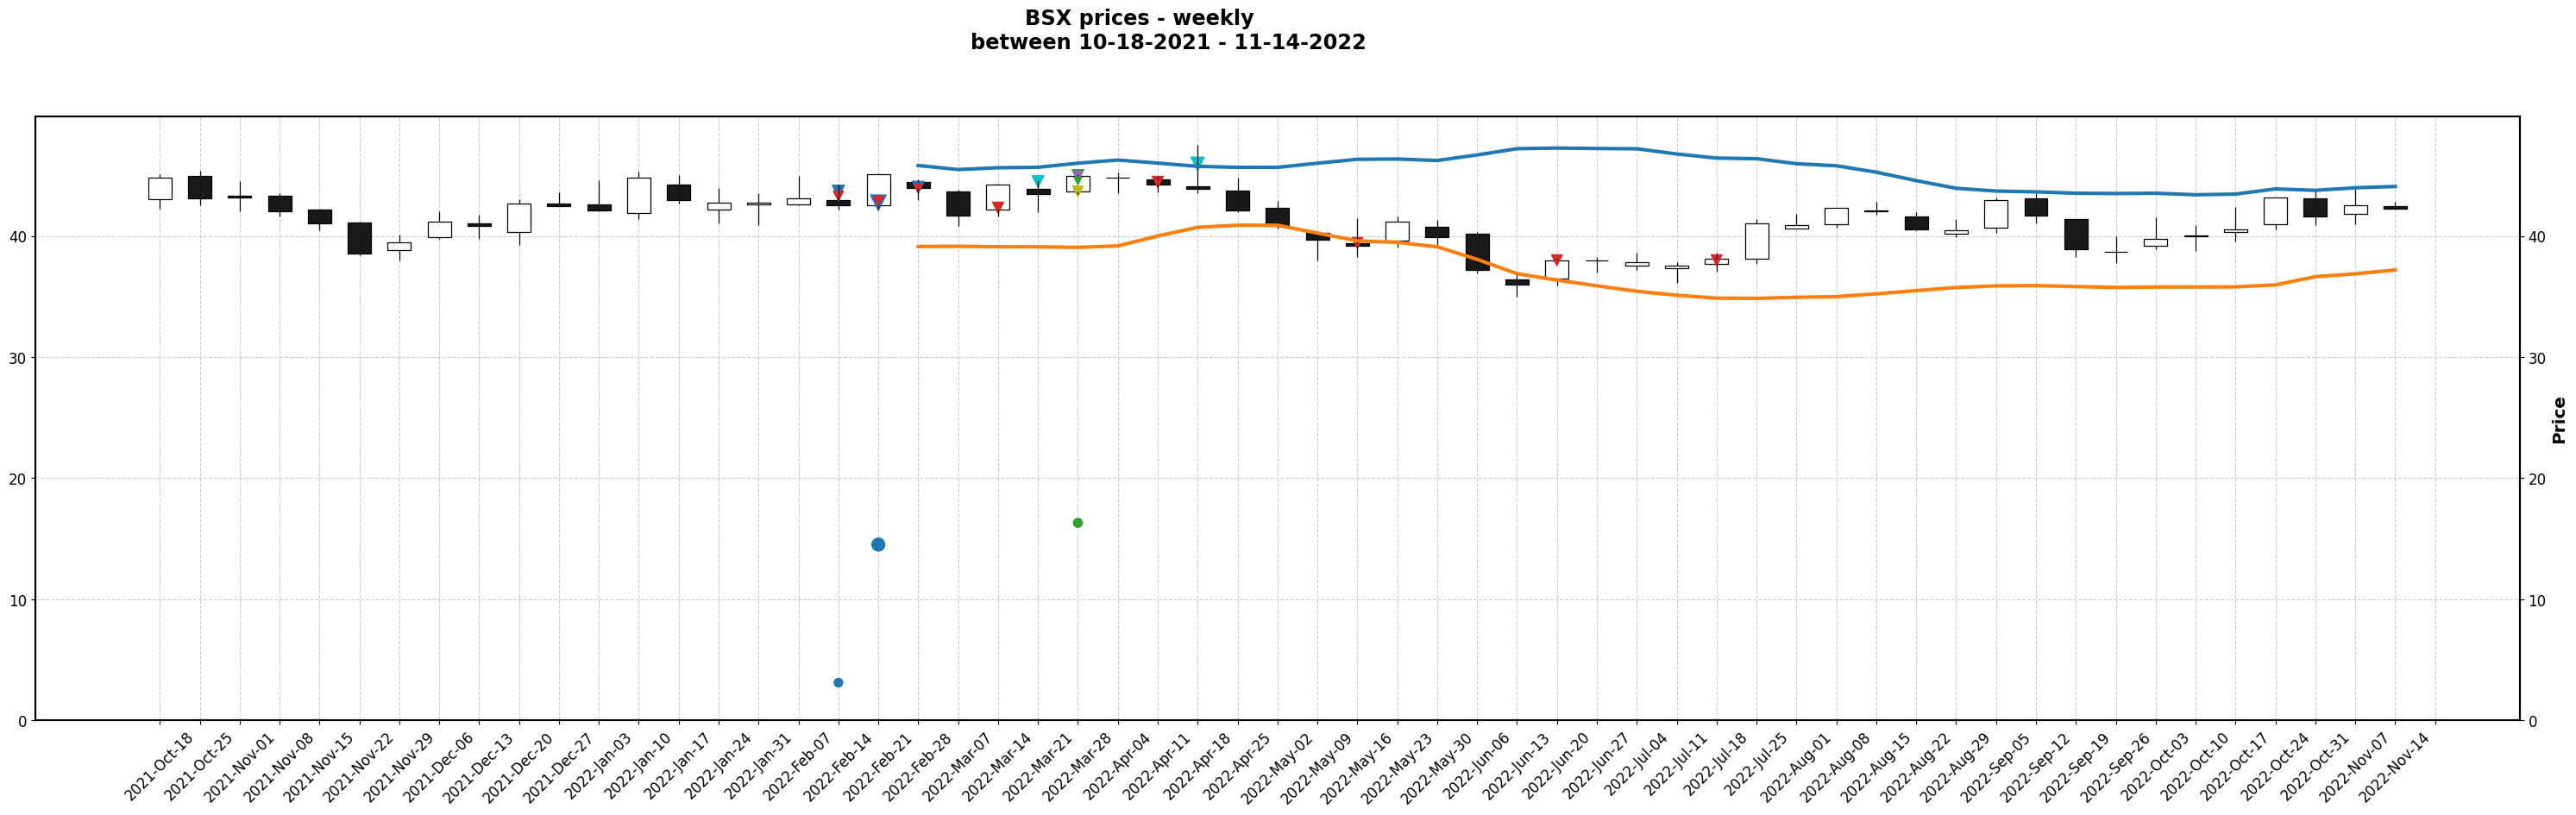

In [5]:
# Weekly View with Bollinger Bands
saHandler.plot_stock_data(ticker_names[1], weekly=True, bollinger=True)

[*********************100%***********************]  1 of 1 completed


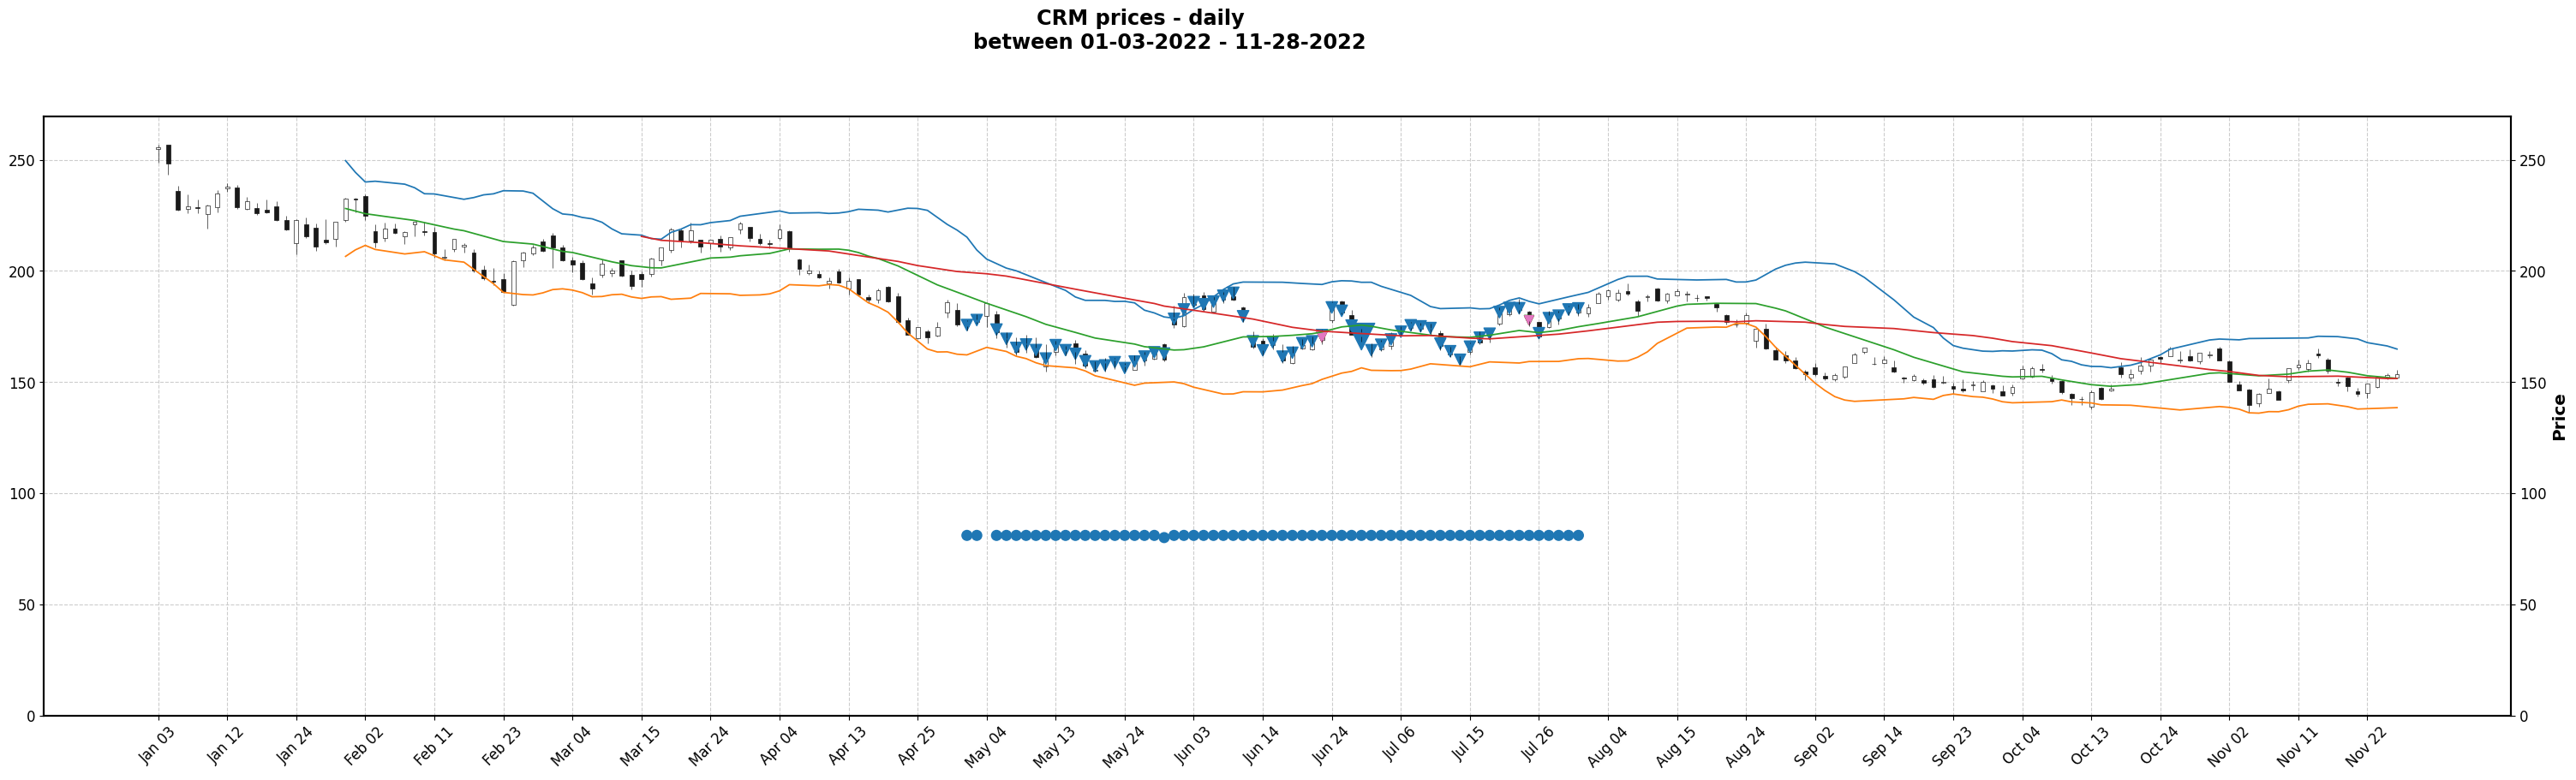

In [6]:
# Daily View with Bollinger Bands and Moving Average 20 and 50
saHandler.plot_stock_data(ticker_names[2], bollinger=True, ma=True, ma_values=[20, 50])

In case we only want the data and not the plot, we can call **StockViewer.get_stock_insider_data()**

The following arguments apply:
- force_download: Bool = False
- weekly: Bool = False
- forward_delta: Integer = 120
- forward_delta: Integer = 120

In [7]:
historical_stock, insider_data = saHandler.get_stock_insider_data('ED', weekly=True)

[*********************100%***********************]  1 of 1 completed


### Sample candlestick patterns

You can also find simple candle stick pattern recognition. The following candlesticks are recognized (to some extent):
- doji
- black_body
- white_body
- dragonfly_doji
- gravestone_doji
- hanging_man
- hammer
- shooting_star
- inv_hammer
- spinning_white
- spinning_black

If it is not recognized, it is marked as **unidentified**

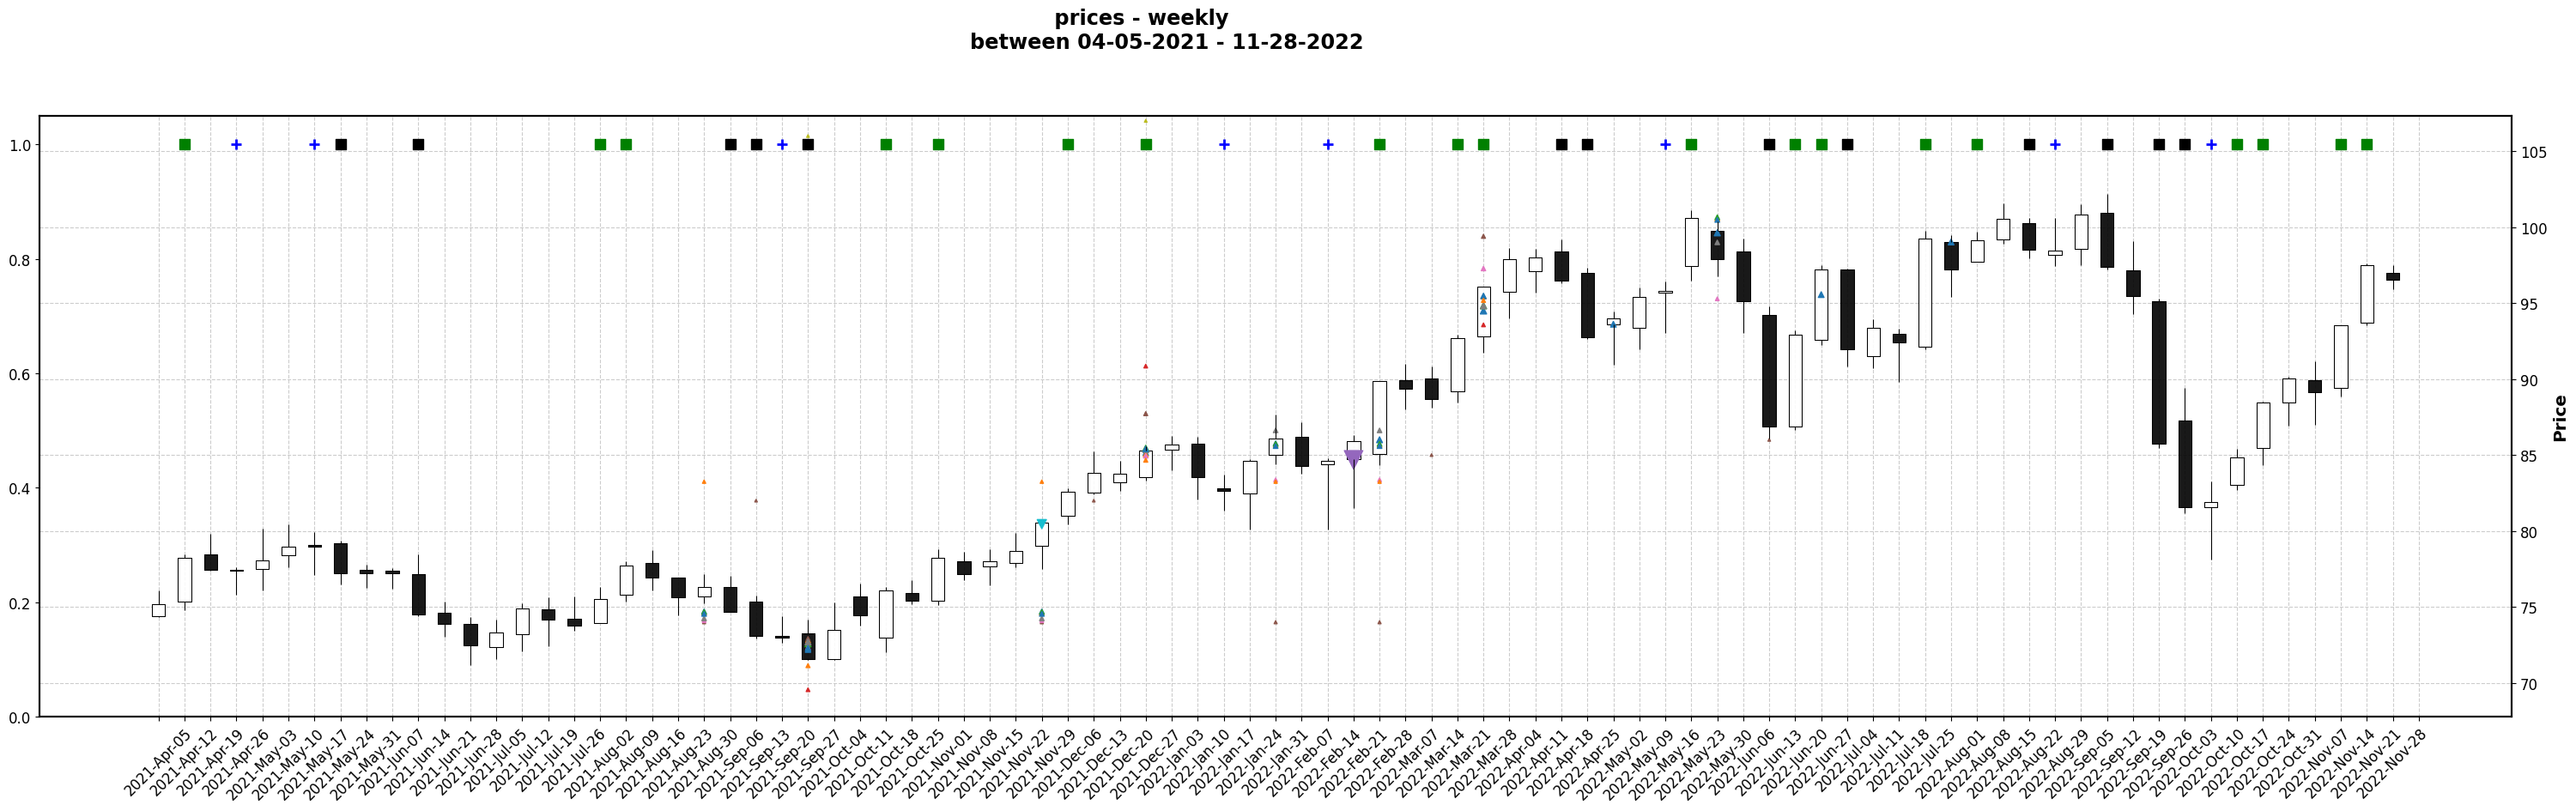

In [8]:
# Make it false to see daily view
weekly_view = True

patterns = sa.assign_simple_patterns(historical_stock.get_view(weekly=weekly_view))
view_func = lambda x, marker, color='blue': mpf.make_addplot(x.replace(False, np.nan), 
                                type="scatter", marker= marker, color=color, markersize=80, ylim=(0,1.05))
apd = [
    view_func(patterns.doji, "+"),
    view_func(patterns.black_body, "s", 'black'),
    view_func(patterns.white_body, "s", 'green')
]

saHandler.plot_stock_data(stock_data=historical_stock, insider_data=insider_data, external_plots=apd, weekly=weekly_view)

## What does data tell us?

We would like to find some sale waves, to achieve that we need to detect some stocks. 

For that:
- We will check an indicator, the options exercised and sold on the same day. 
- This will help us detect interesting stocks.
- After that, we will find sale waves for those interesting stocks.
- With the waves, we will consider the price differences in (at most 8 weeks)

In [9]:
def option_to_sale(insider_data):
    ret = []
    for _person in insider_data.get_by_person():
        sales = _person.get('Sale')
        option = _person.get('Option Exercise')
        
        if sales is None or option is None:
            continue
        
        # Check if insider exercise options and sell them in same day.
        samedat_tx = np.logical_and(sales.Insider, option.Insider).isna()
        sameday_tx = np.logical_not(samedat_tx)
        
        same_amount= sales.Share - option.Share == 0
        mask = np.logical_and(sameday_tx, same_amount)
        if mask.sum() == 0:
            continue

        p_total = sales.loc[mask, [ 'Cost', 'Value']] - option.loc[mask, ['Cost', 'Value']]
        insider = sales.loc[mask, ['Insider', 'Relationship', 'Cost']]
        _df = pd.concat([insider, p_total], axis=1)
        ret.append(_df)

    if len(ret) == 0:
        return pd.DataFrame()
    ret = pd.concat(ret)
    ret.columns =["Insider", 'Relationship', "Cost", "Profit_per_Share", "Total_Profit"]
    return ret

In [10]:
o2s_df = []
for ticker in saHandler.stocks:
    insider = saHandler.get_insider_data(ticker)
    o2s_profit = option_to_sale(insider)
    o2s_profit['Ticker'] = ticker
    o2s_df.append(o2s_profit)
o2s_df = pd.concat(o2s_df)

In [11]:
o2s_df.sort_values('Profit_per_Share', ascending=False).head(200)['Ticker'].value_counts()

MTD     28
AZO     24
TDG     17
ORLY    14
TSLA    14
EPAM    14
IDXX     9
SIVB     9
POOL     9
ISRG     8
NFLX     8
TECH     7
TMO      7
TYL      6
LRCX     6
NVR      5
AMZN     3
BIO      3
DPZ      2
CHTR     1
NVDA     1
UNH      1
ADBE     1
DE       1
GNRC     1
WST      1
Name: Ticker, dtype: int64

MTD and AZO contributes **26%** percent of the highest profits per share. Let's check them

In [12]:
from datetime import timedelta

def find_sale_waves(df, diff_day=20, threshold=3):
    periods = []
    date_index = df.index
    diff_dates = date_index[1:] - date_index[:-1]

    period_cut = timedelta(days=diff_day)

    p_range = [date_index[0], date_index[0]]
    for idx, k in enumerate(diff_dates):
        if k < period_cut:
            p_range[1] = date_index[idx+1]
        else:
            s_period = df.loc[p_range[0]:p_range[1]]
            p_range = [date_index[idx+1], date_index[idx+1]]
            if len(s_period) < threshold:
                continue
            periods.append(s_period)
    
    # handling last item
    s_period = df.loc[p_range[0]:p_range[1]]
    if len(s_period) > threshold:
        periods.append(s_period)
    
    timify = lambda x: x.strftime("%m-%d-%Y")
    # printing periods
    for wave in periods:
        date_start, date_end = wave.index[0], wave.index[-1]
        period_length = date_end - date_start
        date_mean_cost = wave.Cost.mean().round(2)
        print(f"{timify(date_start)} to {timify(date_end)} - {period_length} : {date_mean_cost}")
    return periods

## MTD

[*********************100%***********************]  1 of 1 completed


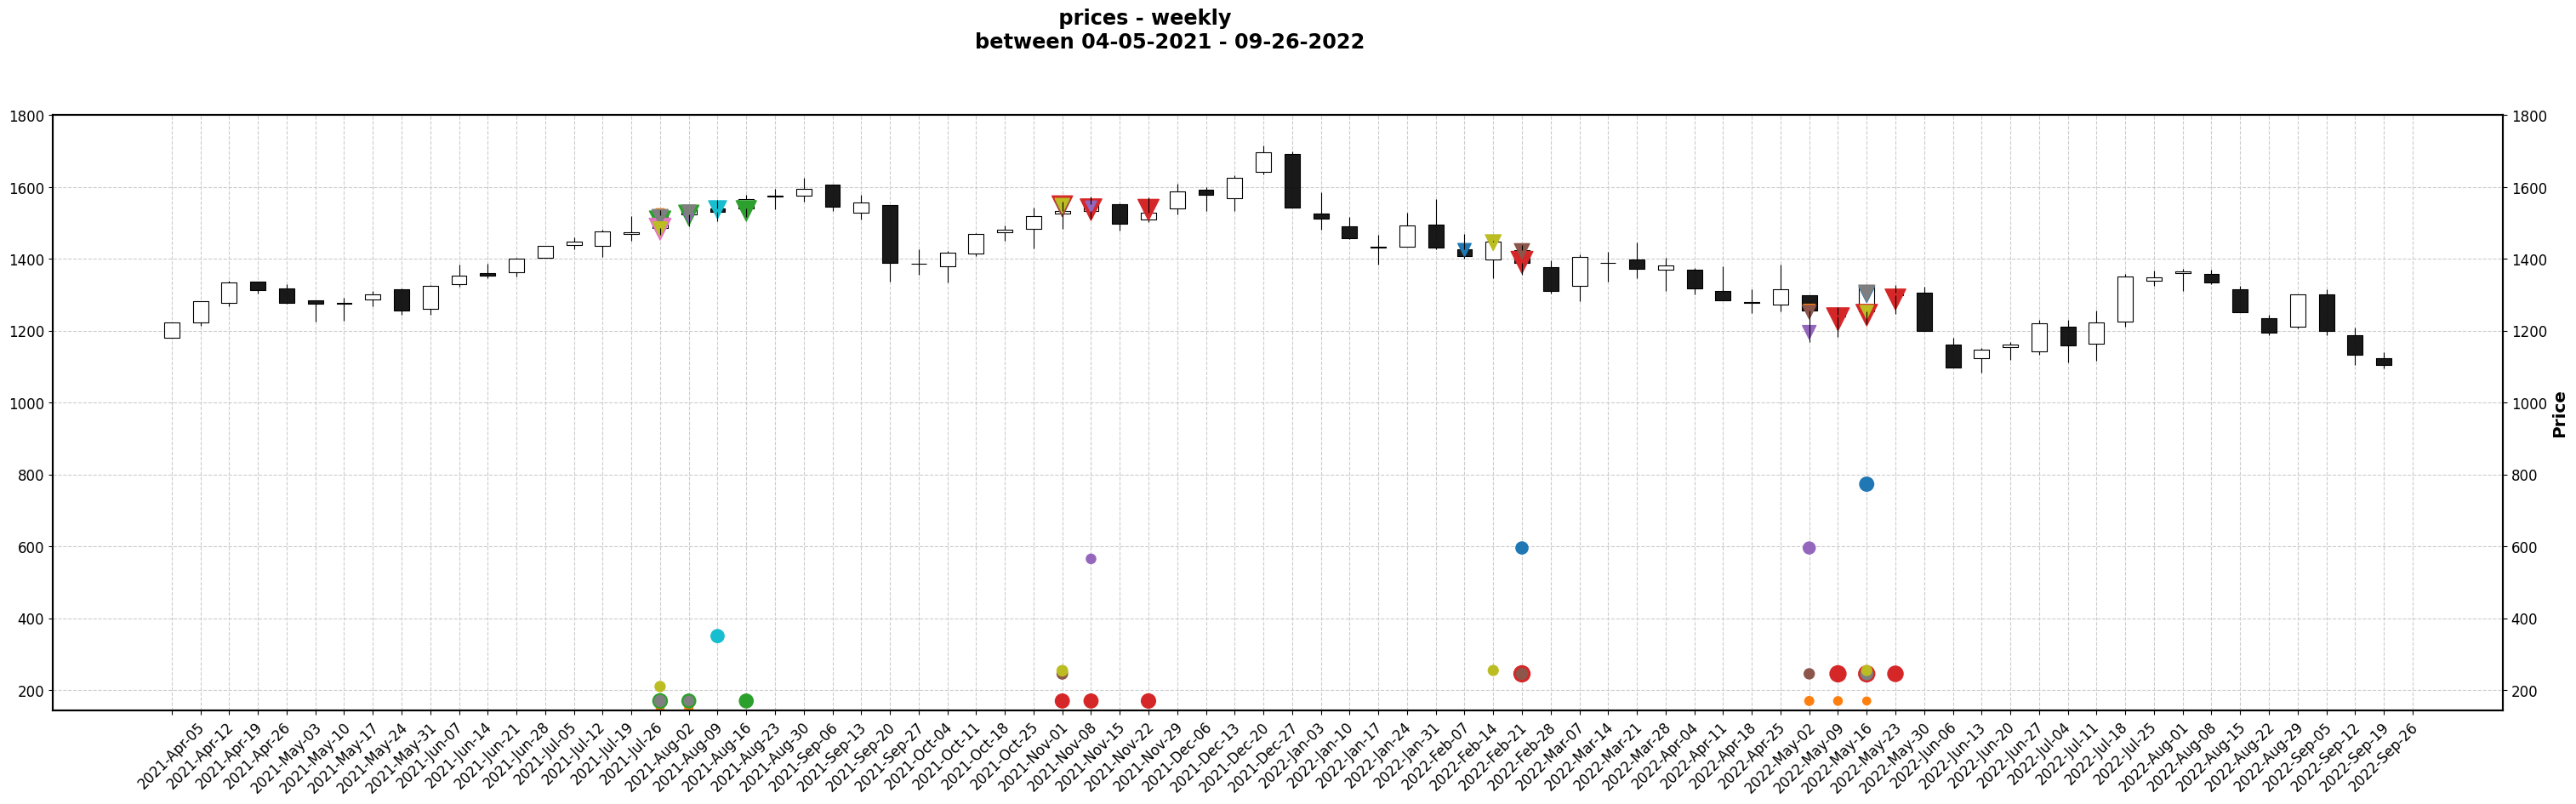

In [13]:
mtd_s, mtd_i = saHandler.get_stock_insider_data('MTD')
saHandler.plot_stock_data(stock_data=mtd_s, insider_data=mtd_i, weekly=True)

In [14]:
mtd_o2s = o2s_df[o2s_df['Ticker']=='MTD'].sort_index()
mtd_waves = find_sale_waves(mtd_o2s)

08-02-2021 to 08-23-2021 - 21 days 00:00:00 : 1510.05
11-09-2021 to 11-29-2021 - 20 days 00:00:00 : 1541.8
02-28-2022 to 03-04-2022 - 4 days 00:00:00 : 1399.31
05-12-2022 to 05-31-2022 - 19 days 00:00:00 : 1259.17


### Sale Waves

There are three waves of sales:
- Aug 02 and Aug 23, 2021
    - Average Cost of Sales 1510.05
    - 4 weeks later - week close: 1389.86
    - 🔻7.96%
- Nov 09 and Nov 29, 2021
    - Average Cost of Sales 1541.8 
    - 7 weeks later - week close: 1458.33
    - 🔻5.41%
- May 02 and May 31, 2022
    - Average Cost of Sales 1259.17
    - 2 weeks later - week close: 1200.44
    - 🔻4.66

The first and second waves are particulary guessed by management.

## AZO

[*********************100%***********************]  1 of 1 completed


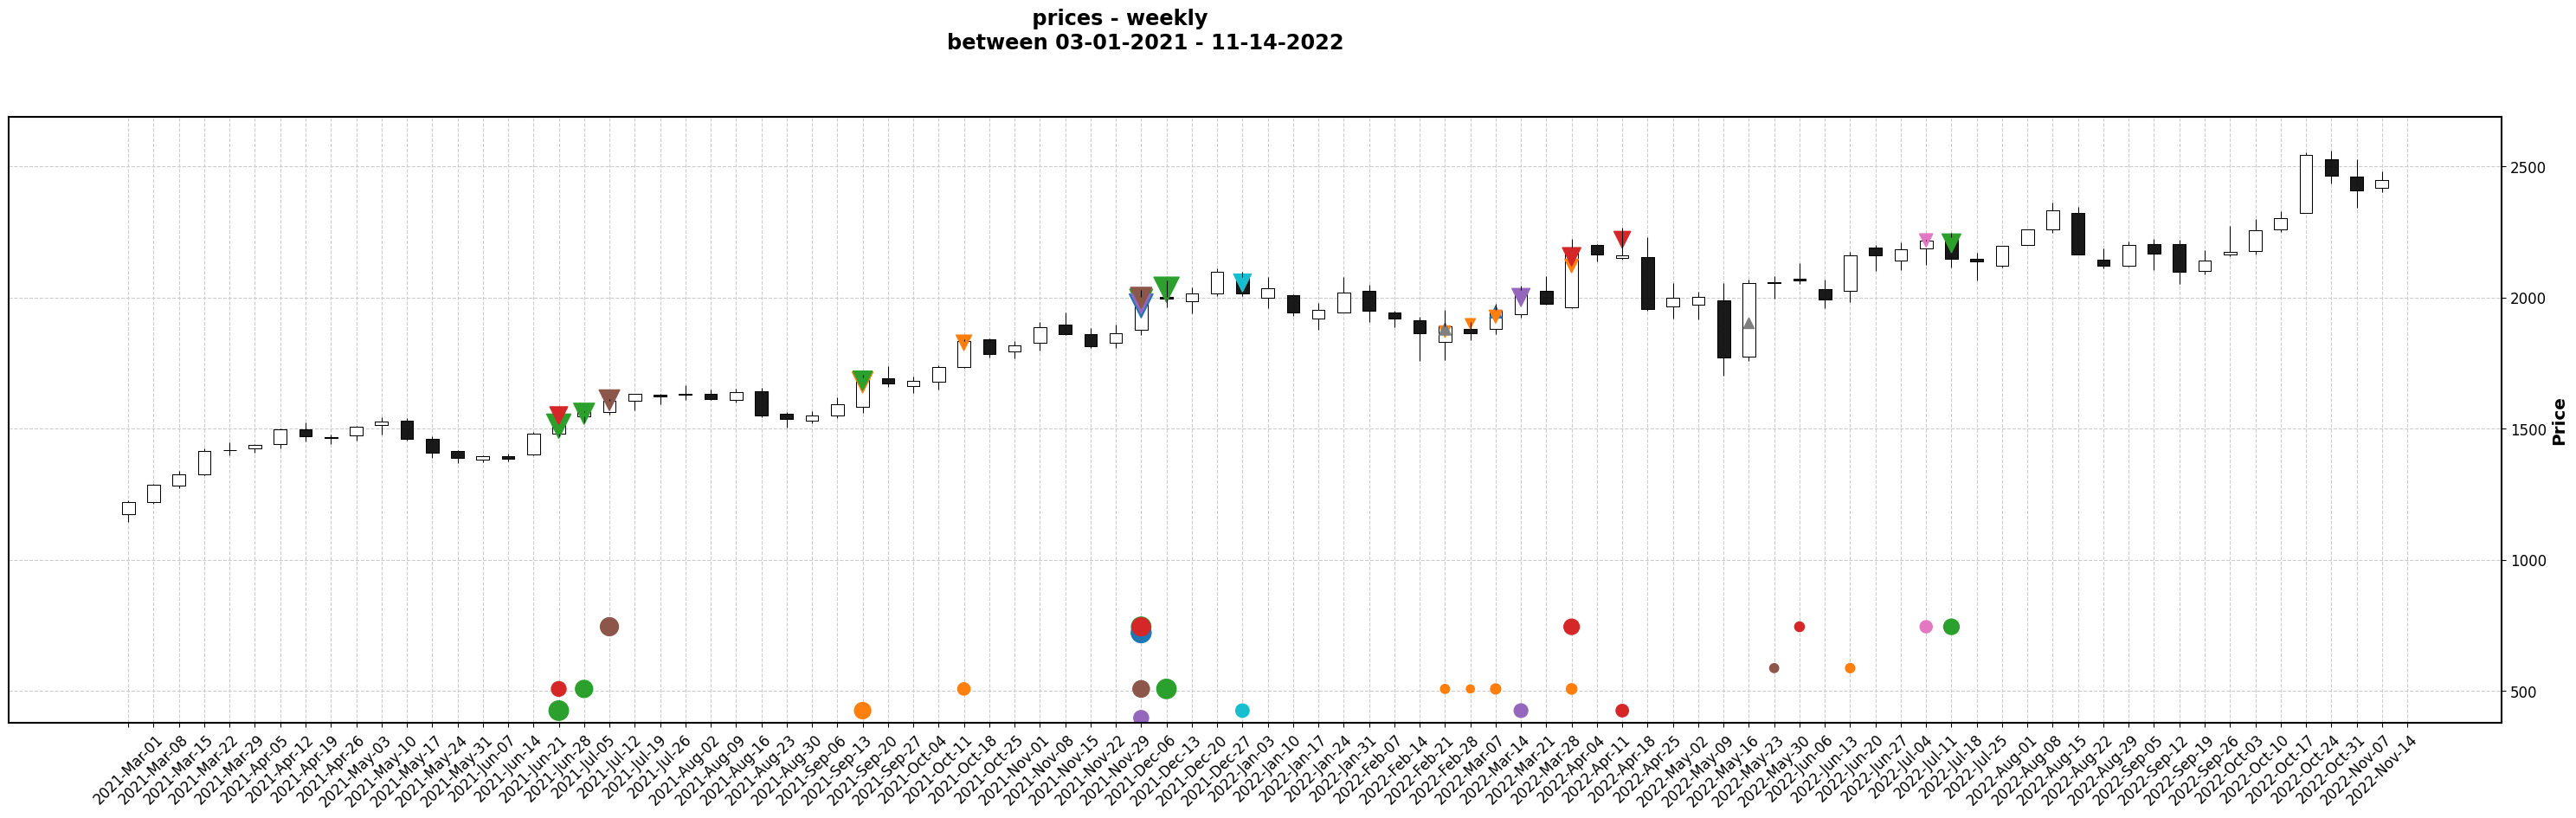

In [15]:
azo_s, azo_i = saHandler.get_stock_insider_data('AZO')
saHandler.plot_stock_data(stock_data=azo_s, insider_data=azo_i, weekly=True)

In [16]:
azo_o2s = o2s_df[o2s_df['Ticker']=='AZO'].sort_index()
azo_waves = find_sale_waves(azo_o2s)

06-29-2021 to 07-16-2021 - 17 days 00:00:00 : 1538.08
12-08-2021 to 01-03-2022 - 26 days 00:00:00 : 2008.25
03-03-2022 to 04-20-2022 - 48 days 00:00:00 : 1979.25


### Sale Waves

There are three waves of sales:
- Jun 29 - Jul 16, 2021
    - Average Cost of Sales 1538.07
    - Prices goes up on following weeks
- Dec 08, 2021 - Jan 03, 2022
    - Average Cost of Sales 2008.25
    - 6 weeks later - week close: 1920
    - 🔻 4.39%

- Mar 03 - Apr 20, 2022
    - Average Cost of Sales 1979.25
    - 4 weeks later - week close: 1771.68
    - 🔻 10,49%

The third wave is expected by management, perhaps they knew something

### Final Remarks

More can be done, but due to time constraints, I am stopping here. Hopefully this notebook and the python scripts are exemplaries for my data engineering and visualization skills along with my data science mindset. Please share your feedback with me, I'm happy to hear your thoughts